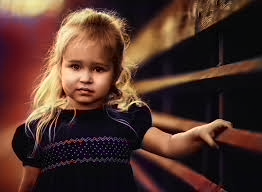

True

In [11]:
import cv2
import numpy as np

from google.colab.patches import cv2_imshow

# loading thr pre-trained model and cluster centers
prototxt = "colorization_deploy_v2.prototxt"
model = "colorization_release_v2.caffemodel"
kernel = "pts_in_hull.npy"

net = cv2.dnn.readNetFromCaffe(prototxt, model)
pts_in_hull = np.load(kernel)

# adding cluster centers to the model
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts_in_hull = pts_in_hull.transpose().reshape(2, 313, 1, 1)

net.getLayer(class8).blobs = [pts_in_hull.astype(np.float32)]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype=np.float32)]

# load grayscale image
# bw_image = cv2.imread("image1.jpg")
bw_image = cv2.imread("image1.jpg")
bw_image = cv2.cvtColor(bw_image, cv2.COLOR_BGR2GRAY)
bw_image = cv2.cvtColor(bw_image, cv2.COLOR_GRAY2BGR)

# Convet image to Lab color space
normalized = bw_image.astype("float32") / 255.0
lab = cv2.cvtColor(normalized, cv2.COLOR_BGR2Lab)
l_channel = lab[:, :, 0]  # Extract L

# resize for network input
resized = cv2.resize(l_channel, (224, 224))
resized -= 50  # Mean-centering as required by model

# PAss through network
net.setInput(cv2.dnn.blobFromImage(resized))
ab_channels = net.forward()[0, :, :, :].transpose((1, 2, 0))

# resizr ab channels to originl size and merge with L channel
ab_channels = cv2.resize(ab_channels, (bw_image.shape[1], bw_image.shape[0]))
lab_out = np.concatenate((l_channel[:, :, np.newaxis], ab_channels), axis=2)

# convert then to BGR
colorized = cv2.cvtColor(lab_out, cv2.COLOR_Lab2BGR)
colorized = np.clip(colorized, 0, 1)
colorized = (255 * colorized).astype("uint8")

# to save and dISPLAY
cv2_imshow(colorized)
cv2.imwrite("colorized_output2.jpg", colorized)
